In [19]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.io import loadmat

Fitted parameters: [4.36378869 2.0686957 ]
Negative Log-Likelihood: 692.0207243120175


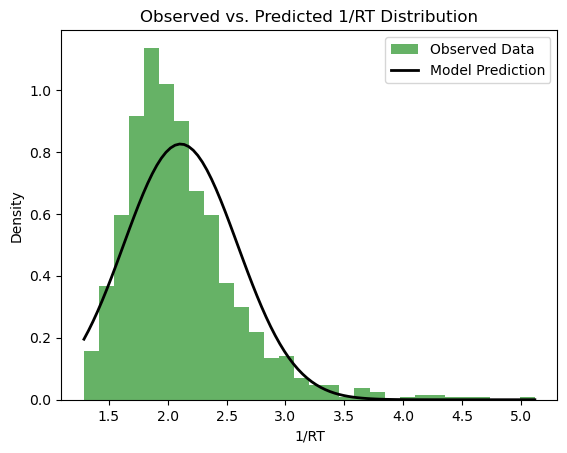

In [1]:
# LATER Fitting Exercise in Python
# Adapted from MATLAB by Joshua I. Gold, University of Pennsylvania
# 2023

# Import necessary libraries


# 1. Get the data
# Placeholder function for data retrieval. Replace this with your data loading logic.
def later_get_data():
    # Simulate RTs as random data for now
    np.random.seed(0)
    RTs = np.random.normal(0.5, 0.1, 1000)
    return RTs

# Get the reaction times
RTs = later_get_data()

# 2. Define the objective function
# Define the log-likelihood function for the LATER model
def later_error_function(fits):
    muR, deltaS = fits
    mu = muR / deltaS
    sigma = 1 / deltaS
    # Log likelihood
    log_likelihoods = norm.logpdf(1 / RTs, loc=mu, scale=sigma)
    return -np.sum(log_likelihoods)  # Minimize negative log-likelihood

# 3. Define initial conditions
# Define the bounds and initial values for the parameters
lower_bounds = [0.001, 0.001]
upper_bounds = [1000, 1000]
bounds = [(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)]

# Set initial values based on rough estimates
initial_values = [1, 0.1]  # Customize these based on your data

# 4. Run the fits
# Use the minimize function from scipy.optimize with constraints
result = minimize(
    later_error_function,
    initial_values,
    bounds=bounds,
    method='L-BFGS-B',  # Similar to 'active-set' in fmincon
    options={'maxiter': 3000}
)

# Extract fitting results
fits = result.x
nllk = result.fun

print("Fitted parameters:", fits)
print("Negative Log-Likelihood:", nllk)

# 5. Evaluate the fits
# Generate predicted 1/RT distribution from the fitted parameters
predicted_mu = fits[0] / fits[1]
predicted_sigma = 1 / fits[1]

# Plot observed vs. model-predicted distributions
plt.hist(1 / RTs, bins=30, density=True, alpha=0.6, color='g', label='Observed Data')
x = np.linspace(min(1 / RTs), max(1 / RTs), 100)
plt.plot(x, norm.pdf(x, loc=predicted_mu, scale=predicted_sigma), 'k', linewidth=2, label='Model Prediction')
plt.xlabel('1/RT')
plt.ylabel('Density')
plt.legend()
plt.title('Observed vs. Predicted 1/RT Distribution')
plt.show()


In [77]:


def later_get_data(subject_tag='FT', data_directory=None, express_cutoff=0.0):
    """
    Function to load RT data for fitting the LATER model.

    Parameters:
    - subject_tag (str): Identifier for the subject's data file.
    - data_directory (str): Path to the directory containing data files.
    - express_cutoff (float): Minimum RT threshold to exclude express saccades.
    
    Returns:
    - data (np.ndarray): Array of RT data for different conditions, where each column represents a condition.
    - labels (list of str): List of condition labels.
    """
    # Define the data directory path if not provided
    if data_directory is None:
        data_directory = os.path.expanduser('/Users/nitarome/Library/CloudStorage/Box-Box/QNC/LATERdata')
    
    # Construct the full file path
    file_path = os.path.join(data_directory, 'data_mgl', 'F', f'{subject_tag}_RT.mat')

    # Load the .mat file
    mat_data = loadmat(file_path)
    
    # Extract necessary data fields
    percorrSum = mat_data['percorrSum'].flatten()
    tRxnSum = mat_data['tRxnSum'].flatten()
    numdirSum = mat_data['numdirSum'].flatten()
    labelSum = mat_data['labelSum'].flatten()

    # Apply criteria for selecting trials
    # 1. Correct trials only
    # 2. Exclude outlier RTs based on express cutoff and maximum threshold
    max_rt_threshold = 1.2  # Upper bound for RT
    Ltrials = (percorrSum == 1) & (tRxnSum > express_cutoff) & (tRxnSum < max_rt_threshold)

    # Organize RTs into four data sets based on conditions
    data_conditions = [
        tRxnSum[Ltrials & (numdirSum == -1) & (labelSum == 1)],   # Left choice, CP
        tRxnSum[Ltrials & (numdirSum == -1) & (labelSum != 1)],   # Left choice, no CP
        tRxnSum[Ltrials & (numdirSum == 1) & (labelSum == 1)],    # Right choice, CP
        tRxnSum[Ltrials & (numdirSum == 1) & (labelSum != 1)]     # Right choice, no CP
    ]

    # Ensure that each condition array has the same length by padding with NaN
    max_len = max(len(d) for d in data_conditions)
    data_padded = [np.pad(d, (0, max_len - len(d)), constant_values=np.nan) for d in data_conditions]

    # Stack the padded data arrays into a 2D NumPy array (each column represents a condition)
    data = np.column_stack(data_padded)

    # Labels for the data sets
    labels = ['Left Choice, CP', 'Left Choice, No CP', 'Right Choice, CP', 'Right Choice, No CP']
    
    return data, labels


In [78]:
data, labels = later_get_data()

In [79]:
data

array([[0.232283, 0.164311, 0.266899, 0.194531],
       [0.21584 , 0.180484, 0.193435, 0.147081],
       [0.177938, 0.180498, 0.201628, 0.12851 ],
       ...,
       [     nan,      nan,      nan, 0.217253],
       [     nan,      nan,      nan, 0.212755],
       [     nan,      nan,      nan, 0.172607]])

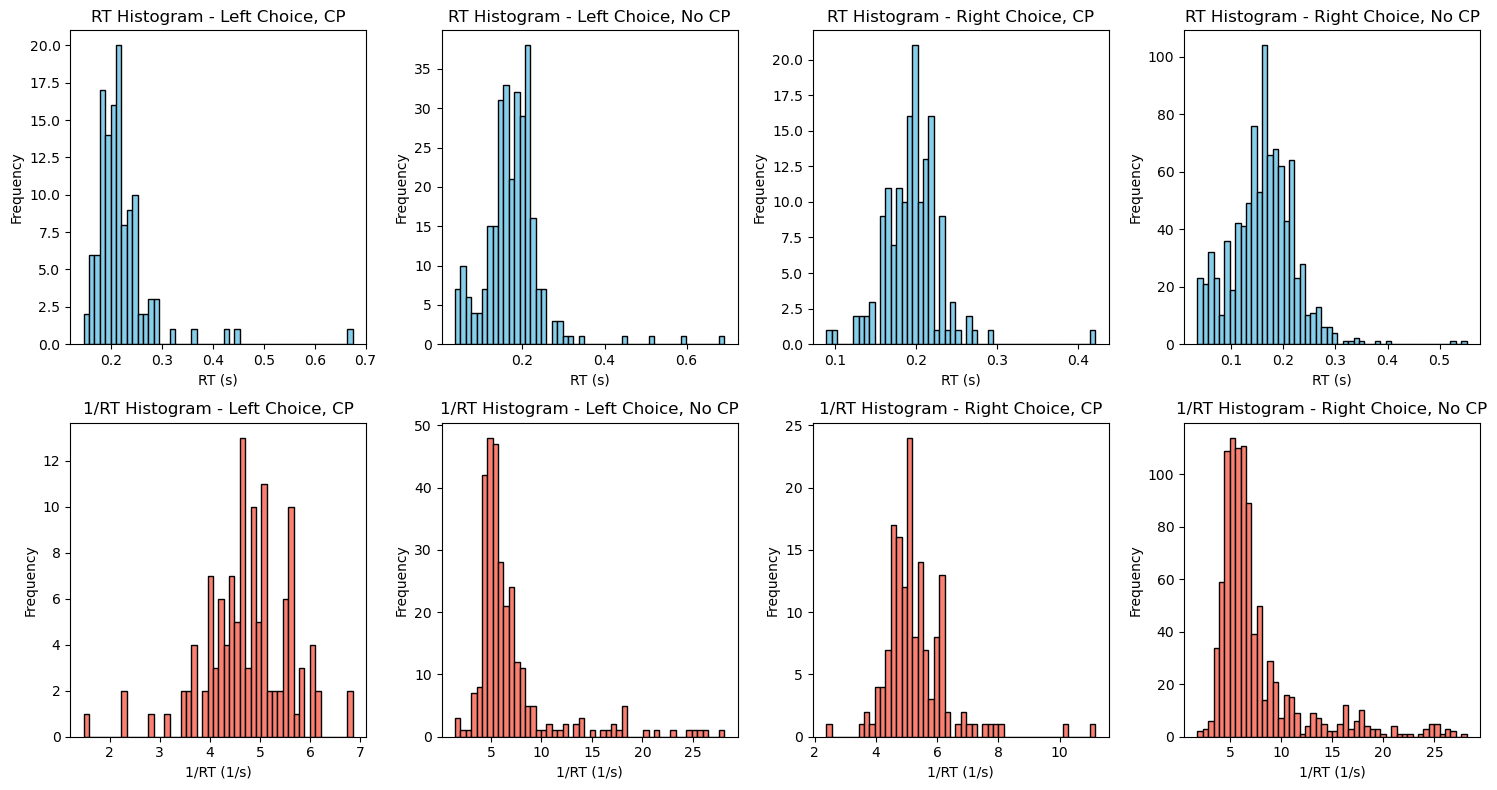

In [80]:
num_conditions = data.shape[1]
fig, axes = plt.subplots(2, num_conditions, figsize=(15, 8), sharey=False)

mu_rtinv = []
sigma_rtinv = []
# Loop through each condition
for i in range(num_conditions):
    # Extract the reaction times for this condition
    rts = data[:, i]
    # Filter out NaN values
    rts = rts[~np.isnan(rts)]
    
    # Calculate inverse reaction times
    inv_rts = 1 / rts

    mu_rtinv.append(np.mean(inv_rts))
    sigma_rtinv.append(np.std(inv_rts))
                    
    
    # Plot histogram for reaction times
    bins = 50
    axes[0, i].hist(rts, bins=bins, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f"RT Histogram - {labels[i]}")
    axes[0, i].set_xlabel("RT (s)")
    axes[0, i].set_ylabel("Frequency")
    
    # Plot histogram for inverse reaction times
    axes[1, i].hist(inv_rts, bins=bins, color='salmon', edgecolor='black')
    axes[1, i].set_title(f"1/RT Histogram - {labels[i]}")
    axes[1, i].set_xlabel("1/RT (1/s)")
    axes[1, i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()



In [88]:
sigma_rtinv

[0.8458381304541849, 4.098743953191971, 1.0357451556244548, 4.355105329082357]

In [90]:
inv_stats = np.array((mu_rtinv,sigma_rtinv))
inv_stats

array([[4.74831824, 6.88395794, 5.28648336, 7.5377326 ],
       [0.84583813, 4.09874395, 1.03574516, 4.35510533]])

#### 2. Define the objective function
 The objective function typically defines the error that you want to 
minimize between your data and the model predictions. A common objective 
 function is the negative of the sum of the log-likelihoods of the data, 
 given the model parameters. To unpack that for the LATER model:

   1. For each data point (RT from a single trial, in this case) and given
       set of model parameters, compute the probability of the data, given
       the model (i.e., the likelihood)
   2. Take the logarithm
   3. Sum all these log-likelihoods from all the data points
   4. Take the negative, because we want to find the minimum (thus
        corresponding to the maximum likelihood)
   You can define the function simply using an "anonymous function"
   (https://www.mathworks.com/help/matlab/matlab_prog/anonymous-functions.html), 
   using this template that assumes that "fits" is a 2x1 vector of
   [muR, deltaS]:

In [104]:
# 2. Define the objective function
# Define the log-likelihood function for the LATER model
def later_error_function(args):
    mu, sigma = args
    # Log likelihood
    log_likelihoods = norm.logpdf(1 / RTs, loc=mu, scale=sigma)
    return -np.sum(log_likelihoods)  # Minimize negative log-likelihood

In [105]:
elower_bounds = [0.001, 0.001]
upper_bounds = [1000, 1000]
bounds = [lower_bounds, upper_bounds]
initial_values = np.array([inv_stats[0,1],inv_stats[0,2]])

In [106]:
initial_values

array([6.88395794, 5.28648336])

In [107]:
result = minimize(later_error_function,
    x0 = [6.88395794, 5.28648336],
    bounds=bounds,
    method='L-BFGS-B',  # Similar to 'active-set' in fmincon
    options={'maxiter': 3000}
)

In [108]:
result

 message: All independent variables were fixed by bounds.
 success: True
     fun: 7826.6961517849195
       x: [ 1.000e-03  1.000e+03]
    nfev: 1
    njev: 0
    nhev: 0